In [1]:
import sys
#!{sys.executable} -m pip install pandas
#!{sys.executable} -m pip install tensorflow
#!{sys.executable} -m pip install sklearn.utils
#!{sys.executable} -m pip install keras
#!{sys.executable} -m pip install keras_tqdm

#!{sys.executable} -m pip install imbalanced-learn

In [22]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn.metrics as metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras_tqdm import TQDMNotebookCallback as ktqdm
from tqdm import tqdm_notebook as tqdm

from matplotlib import pyplot as plt
from imblearn.keras import BalancedBatchGenerator
from keras.models import load_model

In [5]:
def save_model(model, name='model.h5'):
    model.save(name)  # creates a HDF5 file name.h5
    del model         # deletes the existing model

def load_model(model):
    return load_model(model)

## Plotting functions

In [6]:
def plot_history_graph(history, index, label):
    """Plot the graph for the given history metrics."""
    plt.plot(history.history[index], label='Training %s = %0.6f' % (label, history.history[index][-1]))
    plt.plot(history.history['val_%s'%index] , label='Testing %s = %0.6f' % (label, history.history['val_%s'%index][-1]))
    plt.title('Model %s'%label, fontsize=15)
    plt.ylabel(label)
    plt.xlabel('epoch')
    plt.legend(loc='upper right')

In [ ]:
def plot_auroc(history, index, label):
    

## Reproducibility

In [7]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
random.seed(42)
tf.set_random_seed(42)

## Reading csv files

In [9]:
path_classes = "/home/tore/venv/Bioinfo_files/GM12878_class.csv"
path_epigenomic = "/home/tore/venv/Bioinfo_files/GM12878_ep_data.csv"

labels = pd.read_csv(path_classes, names = ["Label"])
epigenomic = pd.read_csv(path_epigenomic, sep=",")

data = (labels.join(epigenomic)).drop("Unnamed: 0", axis=1)
data = data[(data.Label == "A-P") | (data.Label == "I-P")]

data['Label'] = data['Label'].map({'A-P': 1, 'I-P': 0})

## Creating Training and Testing Sets

In [10]:
train, test = train_test_split(
    data,
    test_size=0.3,
    random_state=42,
    shuffle=True)

In [11]:
train.shape, test.shape

((59294, 102), (25413, 102))

In [12]:
ap, ip = train[train.Label == 1], train[train.Label == 0]
len(ip),len(ap)

(51679, 7615)

In [13]:
#Ratio
len(ip)/len(ap)

6.7864740643466845

    Since I-Ps are seven times more circa than A-Ps, a more fair way to use datas is needed.
      
        
## Mini-batch balancing

In [14]:
x_train = train.values[:, train.columns != "Label"]
y_train = train.values[:, train.columns == "Label"]

x_test = test.values[:, test.columns != "Label"]
y_test = test.values[:, test.columns == "Label"]

In [15]:
training_generator = BalancedBatchGenerator(
    x_train,
    y_train,
    batch_size=4096,
    random_state=42)
print(len(training_generator))

3


In [16]:
# for i in range(len(training_generator)):
#     print(type(training_generator[i]))
#     for j in training_generator[i]:
#         print(type(j))
#         print(j)
for i in range(len(training_generator)):
    print(len(training_generator[i][0]))
print(len(training_generator[len(training_generator)][0]))
# print(3*4096+2942)

4096
4096
4096
2942


## Building and running the model (Multi-Layer Perceptron)

In [17]:
def build_model(input_neurons):
    model = Sequential()
    model.add(Dense(64, input_dim=input_neurons, name="Input_dense_layer", activation="sigmoid"))
    #model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(32, name="Second_hidden_layer", activation="sigmoid"))
    model.add(BatchNormalization())
    #model.add(Dropout(0.4))
    model.add(Dense(1, name="Output_layer", activation="sigmoid"))
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=['accuracy'])
    return model

In [18]:
model = build_model(x_train.shape[1])
# model.summary()
save_model(model)

In [19]:
history = model.fit_generator(
    generator=training_generator,
    epochs=300,
    shuffle=True,
    verbose=0,
    callbacks=[ktqdm(metric_format="{name}: {value:e}")],
    validation_data=(x_test, y_test))

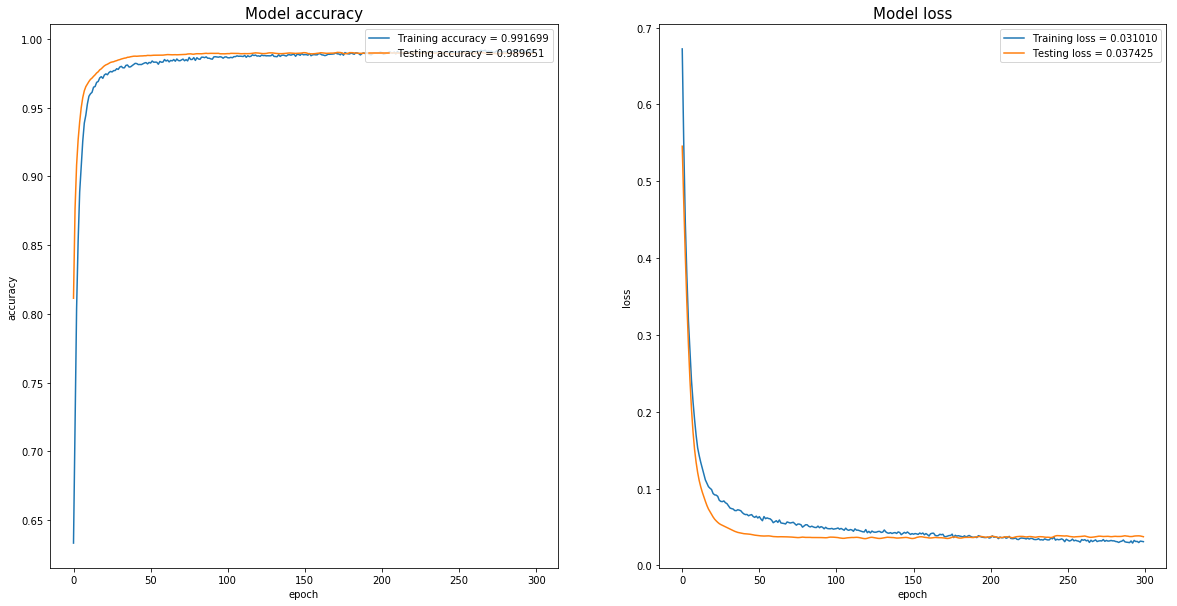

In [20]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plot_history_graph(history, "acc", "accuracy")
plt.subplot(1,2,2)
plot_history_graph(history, "loss", "loss")
plt.show()

## Plotting ROC

In [44]:
probs_test = model.predict_proba(x_test)
probs_train = model.predict_proba(x_train)
preds_test = probs_test[:]
preds_train = probs_train[:]
fpr_test, tpr_test, threshold_test = metrics.roc_curve(y_test, preds_test)
fpr_train, tpr_train, threshold_train = metrics.roc_curve(y_train, preds_train)
roc_auc_test = metrics.auc(fpr_test, tpr_test)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

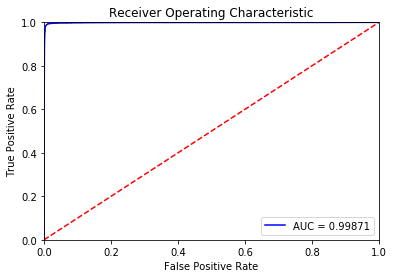

In [48]:
plt.title("Receiver Operating Characteristic")
plt.plot(fpr_train, tpr_train, "b", label= "AUC = %0.5f" % roc_auc_train)
plt.legend(loc= "lower right")
plt.plot([0,1], [0,1], "r--")
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

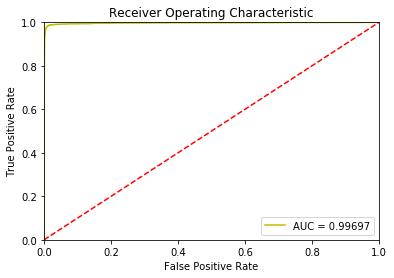

In [47]:
plt.title("Receiver Operating Characteristic")
plt.plot(fpr_test, tpr_test, "y", label= "AUC = %0.5f" % roc_auc_test)
plt.legend(loc= "lower right")
plt.plot([0,1], [0,1], "r--")
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()